In [1]:
using LatticeModels, Plots; LM = LatticeModels
using QuantumOptics
using Plots.Measures

default(fmt=:png,
    fontfamily="computer modern", titlefont="computer modern", tickfont="computer modern";
    linewidth=2, legend_position=:best
 )

We want to reproduce the Bloch oscillation in a ring resonator. A ring resonator with a dynamic refractive index modulation can exhibit Bloch oscillation of light along the frequency axis, as a result of an effective force for photons induced by the modulation, as is shown in [Yuan et al (2016)](https://doi.org/10.1364/OPTICA.3.001014).

Furthermore, we want to show that one can deduce a directional transport on the frequency axis by switching the detuning periodically.

We will implement the model ad deduced in [Yuan et al (2016)](https://doi.org/10.1364/OPTICA.3.001014):
\begin{equation}
\tilde{H}=g \sum_m\left(c_m^{\dagger} c_{m+1}+c_{m+1}^{\dagger} c_m\right)+\sum_m m \Delta(t) c_m^{\dagger} c_m,
\end{equation}
where $m$ is the resonant mode of the waveguide in the resonator, $g$ is the strength of the modulation, and $\Delta$ is the detuning of the resonant frequency of the waveguide from the modulation frequency.

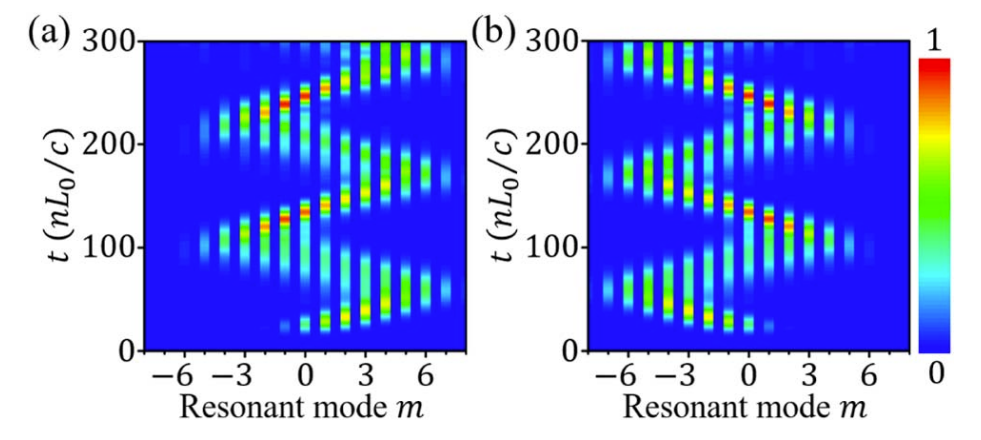

We start by implementing a lattice of 100 sites, i.e., we consider 100 modes of the waveguide. The lattice will have reflective boundary conditions. Furthermore, the tight binding system has one particle and a chemical potential of zero. No extra particles can be added to the system. 

In [2]:
size=100
lattice = SquareLattice(size, 1)
x_basis = PositionBasis(0, size, size)

sample = Sample(lattice, boundaries=BoundaryConditions(1 => true, 2 => true))
system = System(sample, μ=0.0, statistics=LM.OneParticle)

LatticeModels.FilledZones{Sample{Nothing, SquareLattice{2}, Nothing, BoundaryConditions{Tuple{TwistedBoundary, TwistedBoundary}}}}(Sample{Nothing, SquareLattice{2}, Nothing, BoundaryConditions{Tuple{TwistedBoundary, TwistedBoundary}}}(nothing, SquareLattice{2}((100, 1), LatticeModels.Bravais{2, 1}([1.0 0.0; 0.0 1.0], [0.0; 0.0;;]), Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), BoundaryConditions{Tuple{TwistedBoundary, TwistedBoundary}}((TwistedBoundary(1, 0.0), TwistedBoundary(2, 0.0))), nothing), 0.0, LatticeModels.OneParticle)

We implement the time dependent hamiltonian where switch the detuning periodically between -$\Delta$ and +$\Delta$ with a period of $T=1$.

In [3]:
g = 2; Δ = 2
function h(t, g, Δ; switch = t -> isodd(floor(t)) ? -1 : 1)
    build_hamiltonian(lattice,
        lattice .|> (site -> Δ* switch(t)*site.coords[1]),
        g => SiteOffset(axis=1)
    )
end
H0 = h(0, g, Δ)

Hamiltonian(dim=100x100)
  basis: LatticeBasis{SquareLattice{2}}(100, SquareLattice{2}((100, 1), LatticeModels.Bravais{2, 1}([1.0 0.0; 0.0 1.0], [0.0; 0.0;;]), Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
sparse([1, 2, 1, 2, 3, 2, 3, 4, 3, 4  …  97, 98, 97, 98, 99, 98, 99, 100, 99, 100], [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60,

As initial condition, we choose a Gaussian lattice density profile with a width of $\sigma=5$:

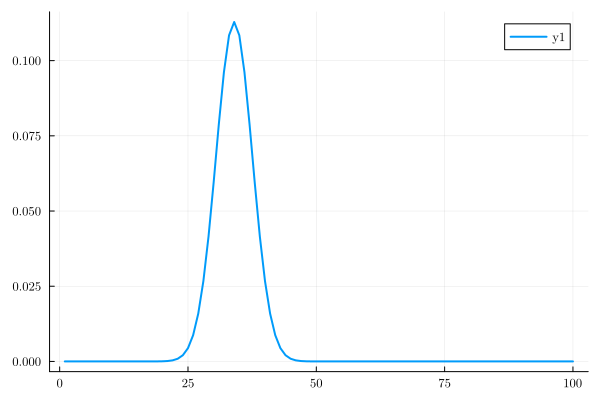

In [4]:
ψx = gaussianstate(x_basis, div(size, 3), 0.0, 5)
ψl = Ket(H0.basis_r, ψx.data)

P0 = Operator(ψl.basis, ψl.data * ψl.data')
d = lattice_density(P0)
plot(d.values)

In [5]:
g = 2; Δ = 2
density_rec = []
@evolution show_progress=false {H := h(t, g, Δ), P0 --> H --> P} for t in 0:0.01:20
    d = lattice_density(P) .|> real
    push!(density_rec,d.values)
end
p1 = heatmap(hcat(density_rec...)', xlabel="lattice site", ylabel="time", title="Δ=±$(Δ)", colorbar=false)

density_rec = []
@evolution show_progress=false {H := h(t, g, Δ, switch= x-> 1), P0 --> H --> P} for t in 0:0.01:20
    d = lattice_density(P) .|> real
    push!(density_rec,d.values)
end
p2 = heatmap(hcat(density_rec...)', xlabel="lattice site", ylabel="time", title="Δ=$(Δ)", colorbar=false)

density_rec = []
@evolution show_progress=false {H := h(t, g, Δ, switch= x-> -1), P0 --> H --> P} for t in 0:0.01:20
    d = lattice_density(P) .|> real
    push!(density_rec,d.values)
end
p3 = heatmap(hcat(density_rec...)', xlabel="lattice site", ylabel="time", title="Δ=-$(Δ)");

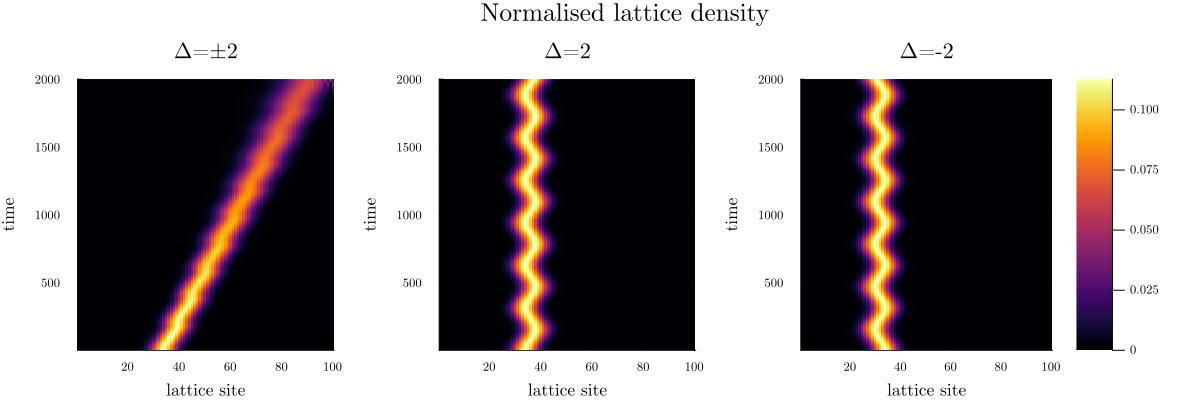

In [6]:
l = @layout [a b c{0.42w}]
plot(p1, p2, p3, layout=l, size=(1200,400), plot_title="Normalised lattice density",
    margin=5mm, plot_titlevspan=0.1)
# savefig(plotsdir("lattice_density.png"))

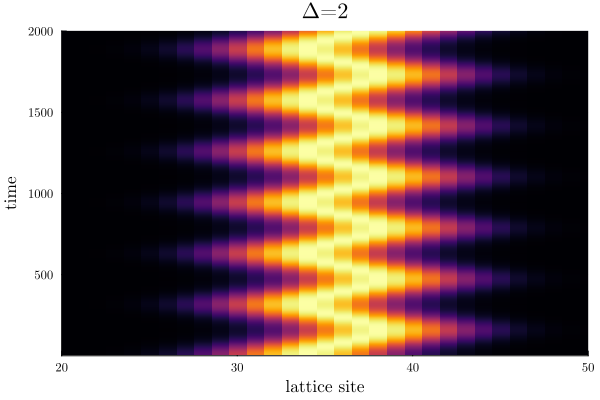

In [7]:
plot(p2, xlim=(20, 50))

In [8]:
function evolution_operator(h, t)
    H = h(t)
    ev_op = Operator(basis(H), H.data)
    LM.evolution_operator!(ev_op, H, t)
    return ev_op
end
time_hamiltonian = t -> h(t, 2, 2)
ev_op = evolution_operator(time_hamiltonian, 2.1)

Operator(dim=100x100)
  basis: LatticeBasis{SquareLattice{2}}(100, SquareLattice{2}((100, 1), LatticeModels.Bravais{2, 1}([1.0 0.0; 0.0 1.0], [0.0; 0.0;;]), Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))sparse([1, 2, 3, 4, 5, 6, 1, 2, 3, 4  …  97, 98, 99, 100, 95, 96, 97, 98, 99, 100], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1